In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import savgol_filter
from scipy.spatial import ConvexHull
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score

# Load the data
dataframe = r"C:\Users\bongo\OneDrive\Desktop\Phenolic compound\flavonoids continuum.xlsx"
df = pd.read_excel(dataframe)

# Extract the X and y data
X = df.iloc[:, 2:]
y = df.iloc[:, 1]

# Get the wavelengths
wavelengths = X.columns.astype(float)

# Remove specified bands
mask = ~((wavelengths >= 1) & (wavelengths <= 603) |
         (wavelengths >= 1355) & (wavelengths <= 1420) |
          (wavelengths >= 1810) & (wavelengths <= 1940) |
          (wavelengths >= 2201) & (wavelengths <= 2500))

X_filtered = X.loc[:, mask]

# Apply Savitzky-Golay filter
window_size = 15
polyorder = 3
X_filtered = savgol_filter(X_filtered, window_size, polyorder, axis=1)

# Prepare for continuum removal
X_cont = np.zeros_like(X_filtered)
for i in range(X_filtered.shape[0]):
    hull = ConvexHull(np.column_stack((wavelengths[mask], X_filtered[i])))
    continuum = np.interp(wavelengths[mask], 
                           wavelengths[mask][hull.vertices], 
                           X_filtered[i][hull.vertices])
    X_cont[i] = X_filtered[i] / continuum

# Convert X_cont back to DataFrame with original column names
X_cont_df = pd.DataFrame(X_cont, columns=X.columns[mask])

# Split the data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X_cont_df, y, test_size=0.3, random_state=41)

# Train the Random Forest Regressor model
rfc = RandomForestRegressor(n_estimators=100, random_state=41)
rfc.fit(X_train, y_train)
y_pred = rfc.predict(X_test)

# Calculate and print the evaluation metrics
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print("Evaluation Metrics:")
print(f"Mean Squared Error: {mse:.2f}")
print(f"R-squared: {r2:.2f}")

# Get the list of features



# Alternatively, if you wanted to convert X_train back to a DataFrame:
# X_train_df = pd.DataFrame(X_train, columns=X.columns[mask])
# f_list = list(X_train_df.columns)


Evaluation Metrics:
Mean Squared Error: 50.78
R-squared: 0.45


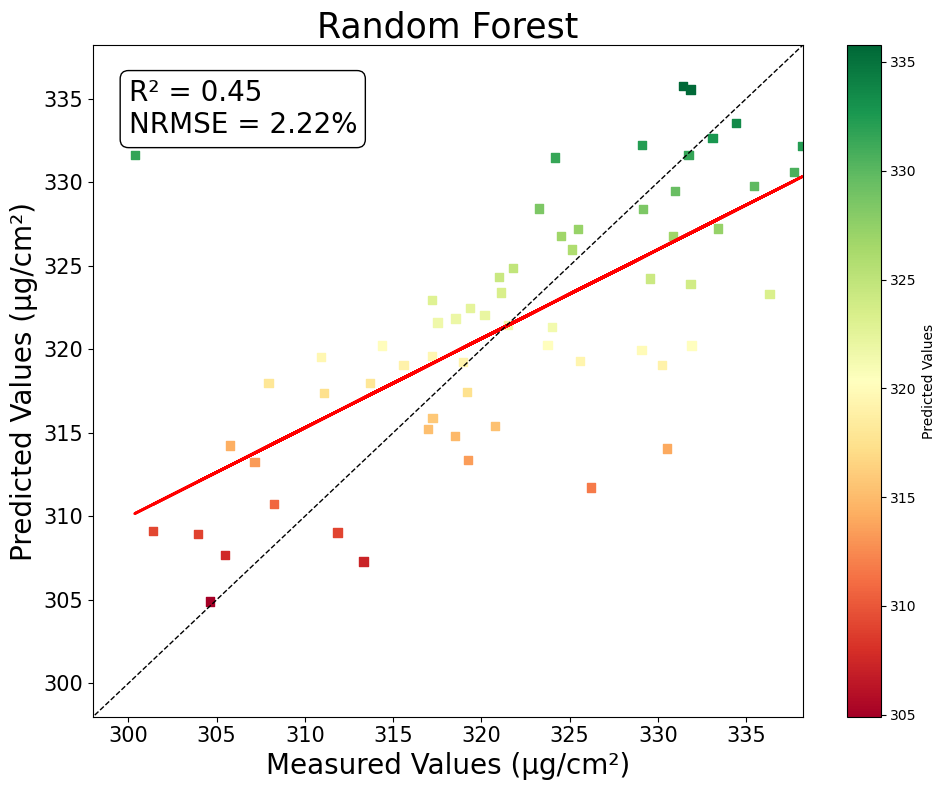

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.linear_model import LinearRegression

# Assuming y_test and y_pred are your actual and predicted values from the Random Forest model
# Calculate R-squared and NRMSE
r2 = r2_score(y_test, y_pred)
nrmse = np.sqrt(mean_squared_error(y_test, y_pred)) / np.mean(y_test) * 100  # NRMSE calculation

# Fit a linear regression model for the regression line
model = LinearRegression()
model.fit(y_test.values.reshape(-1, 1), y_pred)
a = model.coef_[0]
b = model.intercept_

# Create the scatter plot with graduated colors
plt.figure(figsize=(10, 8))
scatter = plt.scatter(y_test, y_pred, c=y_pred, cmap='RdYlGn', marker='s', label='Data Points')

# Plot the linear regression line
plt.plot(y_test, a * y_test + b, color='red', linestyle='-', linewidth=2, label='Regression Line')

# Add the 1:1 line
max_val = max(y_test.max(), y_pred.max())
plt.plot([0, max_val], [0, max_val], color='black', linestyle='--', linewidth=1, label='1:1 Line')

# Add labels and title
plt.xlabel('Measured Values (μg/cm²)', fontsize=20)
plt.ylabel('Predicted Values (μg/cm²)', fontsize=20)
plt.title('Random Forest', fontsize=25)
plt.grid(False)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.colorbar(scatter, label='Predicted Values')

# Add R² and NRMSE (%) information
text = f'R² = {r2:.2f}\nNRMSE = {nrmse:.2f}%'
plt.text(0.05, 0.95, text, transform=plt.gca().transAxes, fontsize=20, verticalalignment='top', bbox=dict(facecolor='white', edgecolor='black', boxstyle='round'))

plt.tight_layout()
plt.xlim(298, max_val)
plt.ylim(298, max_val)
plt.show()